### Sentiment Analysis of the imdb Dataset using Bidirectional LSTM

#### Load Data
- Preprocess Text
- Clean Text
- Tokenize
- Split data to train and test set

#### Model Design
- Build Embeding Matrix
- Create Embeding Layer
- Model Network
- Train Model

#### Model Analysis
- Evalute Train Set
- Evaluate Test Set
- Visual Display

#### Sample reviews based on model

In [15]:
import numpy
import tqdm
import os
import codecs
import pandas as pd
import seaborn as sns

from keras.models import Model
from keras.layers import Conv1D, Dense, LSTM, Dropout, BatchNormalization, Bidirectional
from keras.layers import Embedding, Input
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import numpy as np

#### Load Data


In [2]:
positive_dir = "aclImdb/train/pos"
negative_dir = "aclImdb/train/neg"

#### Preprocess Text


In [3]:
def read_text(filename):
    with codecs.open(filename, encoding='utf8') as f:
            return f.read().lower()

        
print ("Reading negative reviews.")
negative_text = [read_text(os.path.join(negative_dir, filename))
        for filename in tqdm.tqdm(os.listdir(negative_dir), ncols=10)]
        
    
print ("Reading positive reviews.")
positive_text = [read_text(os.path.join(positive_dir, filename))
        for filename in tqdm.tqdm(os.listdir(positive_dir), ncols=10)]


  4%| | 48

Reading negative reviews.


100%|█| 12
  7%| | 88

Reading positive reviews.


100%|█| 12


In [4]:
# declaration of variables
MAX_NB_WORDS = 25000
MAX_SEQUENCE_LENGTH = 200 # 500
N_GLOVE_TOKENS = 400000
EMBEDDING_DIM = 100
epoch = 10

#### Clean Text


In [5]:
labels_index = { "negative": 0, "positive": 1 }

labels = [0 for _ in range(len(negative_text))] + \
        [1 for _ in range(len(negative_text))]
 
texts = negative_text + positive_text

#### Tokenize


In [6]:
# Tokenizer
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

Using TensorFlow backend.


#### Split data to train and test set

In [7]:
# Data Padding
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np_utils.to_categorical(np.asarray(labels))
print ("data.shape = {0}, labels.shape = {1}".format(data.shape, labels.shape))

x_train, x_test, y_train, y_test = train_test_split(data, labels)

data.shape = (25000, 200), labels.shape = (25000, 2)


#### Model Design
- Build Embeding Matrix

In [8]:
# Load word embeddings

print("Loading word embeddings.")
embeddings_index = dict()

with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in tqdm.tqdm(f, total=N_GLOVE_TOKENS):
        values = line.split()
        word, coefficients = values[0], np.asarray(values[1:], dtype=np.float32)
        embeddings_index[word] = coefficients
       

  1%|▊                                                                        | 4621/400000 [00:00<00:09, 40122.05it/s]

Loading word embeddings.


100%|███████████████████████████████████████████████████████████████████████| 400000/400000 [00:09<00:00, 41061.30it/s]


In [9]:
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
print ("embedding_matrix.shape = {0}".format(embedding_matrix.shape))

embedding_matrix.shape = (88583, 100)


#### Create Embeding Layer


In [10]:
# Embedding Layer

embedding_layer = Embedding(len(word_index)+1,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False)

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
embedded_sequences = embedding_layer(sequence_input)

print (embedded_sequences.shape )

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
(?, 200, 100)


#### Model Network


In [12]:
# model design

input_layer = Conv1D(8, 1, activation="relu")(embedded_sequences)

dropout_layer = Dropout(0.3)(input_layer)
normalization_layer = BatchNormalization()(dropout_layer)
lstm_layer = Bidirectional(LSTM(8, dropout=0.2, recurrent_dropout=0.2))(normalization_layer)
dense_layer = Dense(8, activation="relu")(lstm_layer)
output_layer = Dense(len(labels_index), activation="softmax")(dense_layer)

model = Model(sequence_input, output_layer)

print(model.summary())



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          8858300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 8)            808       
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 8)            0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 8)            32        
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136 

In [13]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["acc"])

#### Train Model



In [14]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epoch, batch_size=64, verbose=1)


Train on 18750 samples, validate on 6250 samples
Epoch 1/10
18750/18750 [==============================] - 75s 4ms/step - loss: 0.6925 - acc: 0.5193 - val_loss: 0.6821 - val_acc: 0.5810
Epoch 2/10
18750/18750 [==============================] - 78s 4ms/step - loss: 0.6659 - acc: 0.5911 - val_loss: 0.6056 - val_acc: 0.6864
Epoch 3/10
18750/18750 [==============================] - 80s 4ms/step - loss: 0.6089 - acc: 0.6729 - val_loss: 0.5344 - val_acc: 0.7462
Epoch 4/10
18750/18750 [==============================] - 75s 4ms/step - loss: 0.5752 - acc: 0.7080 - val_loss: 0.5418 - val_acc: 0.7210
Epoch 5/10
18750/18750 [==============================] - 77s 4ms/step - loss: 0.5616 - acc: 0.7137 - val_loss: 0.5060 - val_acc: 0.7630
Epoch 6/10
18750/18750 [==============================] - 75s 4ms/step - loss: 0.5483 - acc: 0.7295 - val_loss: 0.4767 - val_acc: 0.7811
Epoch 7/10
18750/18750 [==============================] - 73s 4ms/step - loss: 0.5368 - acc: 0.7365 - val_loss: 0.4878 - val_acc

#### Model Analysis
- Evaluate Test Set


In [16]:
loss, acc = model.evaluate(x_test, y_test, verbose=1)

print()
print('Test Loss: {:.4f}'.format(loss))
print('Accuracy: {:.2f}%'.format(acc * 100))

6250/6250 [==============================] - 19s 3ms/step

Test Loss: 0.5207
Accuracy: 74.10%


#### Visual Display

In [17]:
### training record
# print(history.history.keys())  ### dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

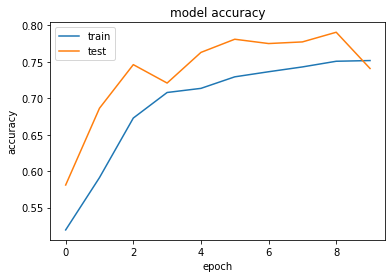

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

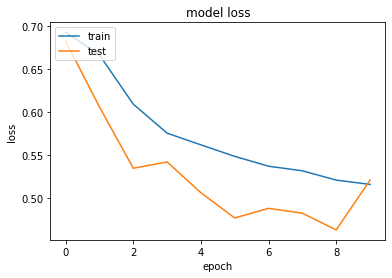

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
predictions = model.predict(x_test)


In [27]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

c:\users\sanmilee\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:>

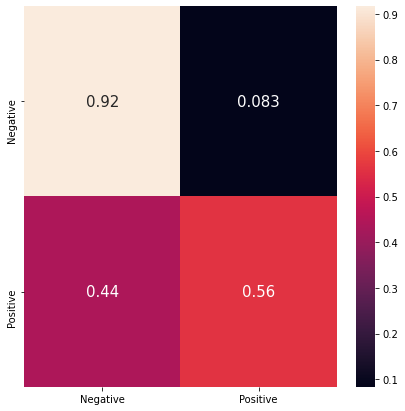

In [33]:
conf_matrix = pd.DataFrame(matrix, index = ['Negative','Positive'],columns = ['Negative','Positive'])

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,7))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

#### Sample reviews based on model

In [34]:
sentiment = ['Negative','Positive']

In [36]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]

'Negative'

In [37]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]


'Positive'

In [39]:
sequence = tokenizer.texts_to_sequences(['Python is neither bad nor good, just there'])
test = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)
sentiment[np.around(model.predict(test), decimals=0).argmax(axis=1)[0]]


'Negative'